In [79]:
import sys
import pathlib
from itertools import product, tee
from dataclasses import dataclass
from typing import Tuple, List

In [70]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import momepy
from shapely import geometry, ops

In [3]:
%load_ext autoreload
%autoreload 2

## Read traffic lanes

Read traffic lanes as geopandas dataframe

In [53]:
trafficlanes_shapefile = pathlib.Path("../data/raw/rdb1/map_rdb1/shapefiles_trafficlanes")
trafficlanes = gpd.read_file(trafficlanes_shapefile)

In [54]:
trafficlanes.head()

,identifier,type,successors,geometry
0,308840,NORMAL,None,"LINESTRING (619275.680 5809210.783, 619270.841..."
1,308827,NORMAL,"1382090,1382091","LINESTRING (619267.575 5809220.289, 619272.474..."
2,307911,NORMAL,"1381550,1381551","LINESTRING (619301.721 5809211.188, 619289.351..."
3,307900,NORMAL,None,"LINESTRING (619290.881 5809202.915, 619303.266..."
4,1381551,NORMAL,307861,"LINESTRING (619289.351 5809205.791, 619286.761..."


Read traffic lanes as a `networkx.classes.digraph.DiGraph`

In [57]:
traffic_lanes_graph = momepy.gdf_to_nx(trafficlanes, approach='primal', directed=True, multigraph=False)

In [58]:
traffic_lanes_graph

In [59]:
len(traffic_lanes_graph.nodes), len(traffic_lanes_graph.edges)

(44, 48)

Find nodes with only one incoming and outgoing edge

In [60]:
start_nodes = [node for node, degree in traffic_lanes_graph.in_degree if degree == 0]
end_nodes = [node for node, degree in traffic_lanes_graph.out_degree if degree == 0]

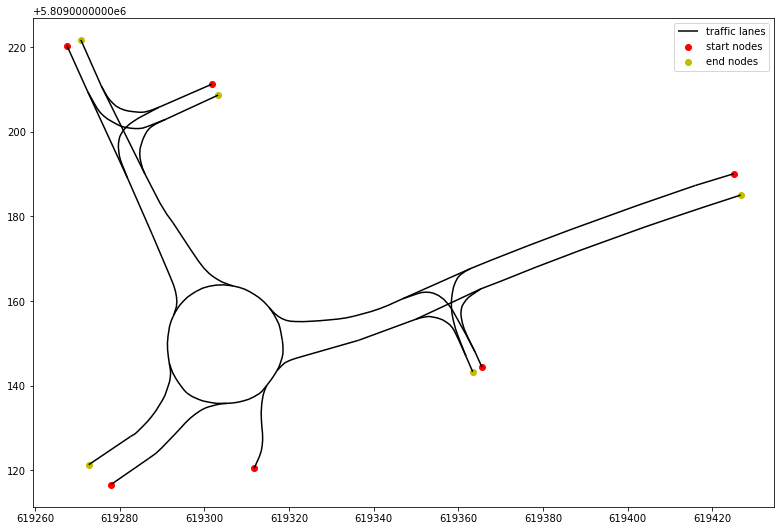

In [61]:
fig, ax = plt.subplots(figsize=(16, 9))
trafficlanes.plot(ax=ax, color="k", label="traffic lanes")

start_nodes_matrix = np.array(start_nodes)
ax.scatter(start_nodes_matrix[:, 0], start_nodes_matrix[:, 1], color="r", label="start nodes")

end_nodes_matrix = np.array(end_nodes)
ax.scatter(end_nodes_matrix[:, 0], end_nodes_matrix[:, 1], color="y", label="end nodes")

ax.legend()

Find all possible paths between the combination of start- and end nodes

In [80]:
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [90]:
@dataclass
class DrivablePath:
    id: int
    path: List[Tuple[float, float]]
    
    def plot(self, ax, as_linestring = False, graph = None):
        if as_linestring:
            ls = self.linestring(graph)
            x, y = ls.xy
            ax.plot(x, y, label=str(self.id))
            ax.scatter([x[0], x[-1]], [y[0], y[-1]])
        else:
            path_matrix = np.array(self.path)
            ax.plot(path_matrix[:, 0], path_matrix[:, 1], label=str(self.id))
        
    def linestring(self, G):
        lines = list()
        for n0, n1 in pairwise(self.path):
            geometry = G.edges[n0, n1]['geometry']
            lines.append(geometry)
        ls = ops.linemerge(lines)
        return ls

In [91]:
paths = list()
for i, (start, end) in enumerate(product(start_nodes, end_nodes)):
    path = nx.shortest_path(traffic_lanes_graph, start, end)
    paths.append(DrivablePath(i, path))

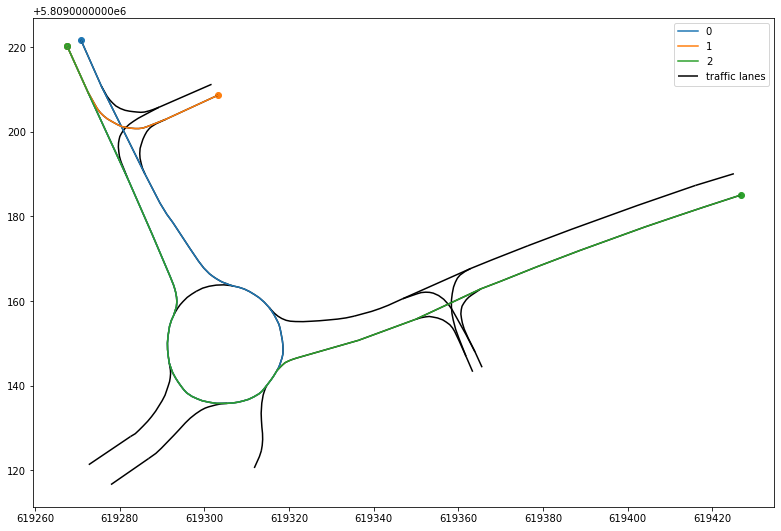

In [92]:
fig, ax = plt.subplots(figsize=(16, 9))
trafficlanes.plot(ax=ax, color="k", label="traffic lanes")

for dp in paths[:3]:
    dp.plot(ax, as_linestring=True, graph=traffic_lanes_graph)

ax.legend()